In [835]:
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
from tflearn.data_utils import to_categorical
from collections import Counter, defaultdict
from sklearn.feature_extraction import stop_words

In [836]:
results = pd.read_csv('indeed-results.csv')
results.head()

,location,title,company,salary,summary
0,"Charlotte, NC",Sr. Data Scientist,ACT-Consulting,$102 an hour,Coordinate and lead meetings to review the ove...
1,"San Mateo, CA",Jr. Data Scientist,Harnham,"$130,000 a year",Associate Data Scientist. This is an exciting ...
2,"Minneapolis, MN 55439",Sr. Data Scientist,RED SKY Consulting,"$120,000 a year","Data Architect, BI Architect, Data Scientist, ..."
3,"Manhattan, NY",Jr. Data Scientist,DEPARTMENT OF TRANSPORTATION,"$60,189 - $83,440 a year","Establish and monitor best practices, policies..."
4,"New York, NY",Jr. Data Scientist,"Envisagenics, Inc.","$65,000 - $110,000 a year",We are looking for experts in machine learning...


In [837]:
results.shape

(174, 5)

## Data Wrangling & Preprocessing


In [838]:
salaries_sal = results[results.salary.notnull()]
salaries_summ = salaries_sal[salaries_sal.summary.notnull()]
salaries = salaries_summ[salaries_summ.company.notnull()]

In [839]:
salaries.dtypes

location    object
title       object
company     object
salary      object
summary     object
dtype: object

In [840]:
salaries.head()

,location,title,company,salary,summary
0,"Charlotte, NC",Sr. Data Scientist,ACT-Consulting,$102 an hour,Coordinate and lead meetings to review the ove...
1,"San Mateo, CA",Jr. Data Scientist,Harnham,"$130,000 a year",Associate Data Scientist. This is an exciting ...
2,"Minneapolis, MN 55439",Sr. Data Scientist,RED SKY Consulting,"$120,000 a year","Data Architect, BI Architect, Data Scientist, ..."
3,"Manhattan, NY",Jr. Data Scientist,DEPARTMENT OF TRANSPORTATION,"$60,189 - $83,440 a year","Establish and monitor best practices, policies..."
4,"New York, NY",Jr. Data Scientist,"Envisagenics, Inc.","$65,000 - $110,000 a year",We are looking for experts in machine learning...


In [841]:
salaries.shape

(157, 5)

In [842]:
salaries = salaries[(~salaries.salary.str.contains('an hour')) & (~salaries.salary.str.contains('a month'))
                   & (~salaries.salary.str.contains('a week')) & (~salaries.salary.str.contains('a day'))]

In [843]:
salaries.salary = salaries.salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')

In [844]:
salaries.shape

(141, 5)

In [845]:
for i in salaries.salary:
    if len(i.split('-')) != 1 and len(i.split('-')) != 2:
        print(i)

In [846]:
new_salaries = []
for i in salaries.salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))

In [847]:
new_salaries[0:5]

[130000.0, 120000.0, 71814.5, 87500.0, 220000.0]

In [848]:
salaries.salary = new_salaries

In [849]:
salaries.head()

,location,title,company,salary,summary
1,"San Mateo, CA",Jr. Data Scientist,Harnham,130000.0,Associate Data Scientist. This is an exciting ...
2,"Minneapolis, MN 55439",Sr. Data Scientist,RED SKY Consulting,120000.0,"Data Architect, BI Architect, Data Scientist, ..."
3,"Manhattan, NY",Jr. Data Scientist,DEPARTMENT OF TRANSPORTATION,71814.5,"Establish and monitor best practices, policies..."
4,"New York, NY",Jr. Data Scientist,"Envisagenics, Inc.",87500.0,We are looking for experts in machine learning...
5,"New York, NY",Chief Data Scientist,Harnham,220000.0,Chief Data Scientist - Consulting. Chief Data ...


In [850]:
salaries.shape

(141, 5)

In [851]:
salaries.duplicated().sum()

0

In [852]:
salaries.isnull().sum()

location    0
title       0
company     0
salary      0
summary     0
dtype: int64

In [853]:
#display null columns

null_columns=salaries.columns[salaries.isnull().any()]
print(salaries[salaries.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [854]:
salaries.head()

,location,title,company,salary,summary
1,"San Mateo, CA",Jr. Data Scientist,Harnham,130000.0,Associate Data Scientist. This is an exciting ...
2,"Minneapolis, MN 55439",Sr. Data Scientist,RED SKY Consulting,120000.0,"Data Architect, BI Architect, Data Scientist, ..."
3,"Manhattan, NY",Jr. Data Scientist,DEPARTMENT OF TRANSPORTATION,71814.5,"Establish and monitor best practices, policies..."
4,"New York, NY",Jr. Data Scientist,"Envisagenics, Inc.",87500.0,We are looking for experts in machine learning...
5,"New York, NY",Chief Data Scientist,Harnham,220000.0,Chief Data Scientist - Consulting. Chief Data ...


In [855]:
##### dist plotting

In [856]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


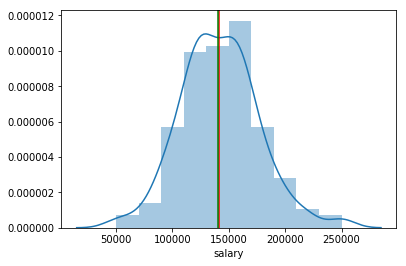

In [857]:
ax = sns.distplot(salaries['salary'], bins=10)
ax.axvline(salaries['salary'].mean(), c='r')
ax.axvline(salaries['salary'].median(), c='g')

In [858]:
twentieth = salaries['salary'].quantile(0.20)
eightieth = salaries['salary'].quantile(0.80)

In [859]:
median_salary = np.median(salaries.salary)
median_salary

140000.0

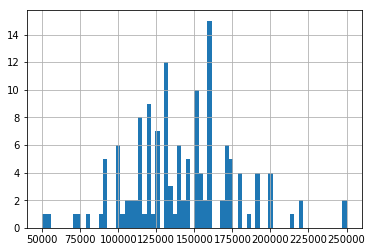

In [860]:

# Salary of different jobs
salaries['salary'].hist(bins = 70)

In [861]:
salaries['high_salary'] = [1 if i > median_salary else 0 for i in salaries.salary]

## Pre processing for vectorization

In [862]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split

In [863]:
## Count Number of words in each summary of job

salaries['word_count'] = salaries['summary'].apply(lambda x: len(str(x).split(" ")))
salaries[['summary','word_count']].head()

,summary,word_count
1,Associate Data Scientist. This is an exciting ...,23
2,"Data Architect, BI Architect, Data Scientist, ...",19
3,"Establish and monitor best practices, policies...",22
4,We are looking for experts in machine learning...,14
5,Chief Data Scientist - Consulting. Chief Data ...,22


In [864]:
## Count Number of characters in each summary of job

salaries['char_count'] = salaries['summary'].str.len() ## this also includes spaces
salaries[['summary','char_count']].head()

,summary,char_count
1,Associate Data Scientist. This is an exciting ...,159
2,"Data Architect, BI Architect, Data Scientist, ...",163
3,"Establish and monitor best practices, policies...",162
4,We are looking for experts in machine learning...,107
5,Chief Data Scientist - Consulting. Chief Data ...,154


In [865]:
#check for stop words

import nltk
#nltk.download()
from nltk.corpus import stopwords
stop = stopwords.words('english')

salaries['stopwords'] = salaries['summary'].apply(lambda x: len([x for x in x.split() if x in stop]))
salaries[['summary','stopwords']].head()

,summary,stopwords
1,Associate Data Scientist. This is an exciting ...,6
2,"Data Architect, BI Architect, Data Scientist, ...",0
3,"Establish and monitor best practices, policies...",4
4,We are looking for experts in machine learning...,3
5,Chief Data Scientist - Consulting. Chief Data ...,0


In [866]:
## make everything lowercase

salaries['summary'] = salaries['summary'].apply(lambda x: x.lower())
salaries['summary'].head()

1    associate data scientist. this is an exciting ...
2    data architect, bi architect, data scientist, ...
3    establish and monitor best practices, policies...
4    we are looking for experts in machine learning...
5    chief data scientist - consulting. chief data ...
Name: summary, dtype: object

In [867]:
salaries['title'] = salaries['title'].apply(lambda x: x.lower())
salaries['title'].head(10)

1       jr. data scientist
2       sr. data scientist
3       jr. data scientist
4       jr. data scientist
5     chief data scientist
6           data scientist
7           data scientist
8           data scientist
9           data scientist
10          data scientist
Name: title, dtype: object

In [868]:
salaries['title'] = salaries['title'].str.replace('[^\w\s]',' ')
salaries['title'].head(20)

1       jr  data scientist
2       sr  data scientist
3       jr  data scientist
4       jr  data scientist
5     chief data scientist
6           data scientist
7           data scientist
8           data scientist
9           data scientist
10          data scientist
11          data scientist
12          data scientist
13          data scientist
15          data scientist
16          data scientist
18          data scientist
19          data scientist
21          data scientist
22          data scientist
24          data scientist
Name: title, dtype: object

In [869]:
# Remove punctuations

salaries['summary'] = salaries['summary'].str.replace('[^\w\s]','')
salaries['summary'].head()


1    associate data scientist this is an exciting o...
2    data architect bi architect data scientist dat...
3    establish and monitor best practices policies ...
4    we are looking for experts in machine learning...
5    chief data scientist  consulting chief data sc...
Name: summary, dtype: object

In [870]:
import re
states = ['IA', 'KS', 'UT', 'VA', 'NC', 'NE', 'SD', 'AL', 'ID', 'FM', 'DE', 'AK', 'CT', 'PR', 'NM', 'MS', 'PW', 'CO', 'NJ', 'FL', 'MN', 'VI', 'NV', 'AZ', 'WI', 'ND', 'PA', 'OK', 'KY', 'RI', 'NH', 'MO', 'ME', 'VT', 'GA', 'GU', 'AS', 'NY', 'CA', 'HI', 'IL', 'TN', 'MA', 'OH', 'MD', 'MI', 'WY', 'WA', 'OR', 'MH', 'SC', 'IN', 'LA', 'MP', 'DC', 'MT', 'AR', 'WV', 'TX']
regex = re.compile(r'\b(' + '|'.join(states) + r')\b')
salaries['location'] = salaries['location'].str.replace(',', '').str.extract(regex)

In [871]:
salaries['location'].head(10)

1     CA
2     MN
3     NY
4     NY
5     NY
6     MA
7     CA
8     NY
9     NY
10    NY
Name: location, dtype: object

In [872]:
# Check for rare words

freq = pd.Series(' '.join(salaries['summary']).split()).value_counts()[-10:]
freq

scale         1
primary       1
integrate     1
turn          1
patterns      1
actionable    1
heavily       1
prediction    1
take          1
trends        1
dtype: int64

In [873]:
# Correct Spellings

# import textblob
# from textblob import TextBlob
# salaries['summary'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [874]:
#Remove Stop words

stop = stopwords.words('english')
salaries['summary']  = salaries['summary'] .apply(lambda x: " ".join(x for x in x.split() if x not in stop))
salaries['summary'].head()

1    associate data scientist exciting opportunity ...
2    data architect bi architect data scientist dat...
3    establish monitor best practices policies proc...
4    looking experts machine learning genomics rnas...
5    chief data scientist consulting chief data sci...
Name: summary, dtype: object

In [875]:
## Stemming

from nltk.stem import PorterStemmer
st = PorterStemmer()
salaries['summary'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
salaries['summary'].head()

1    associate data scientist exciting opportunity ...
2    data architect bi architect data scientist dat...
3    establish monitor best practices policies proc...
4    looking experts machine learning genomics rnas...
5    chief data scientist consulting chief data sci...
Name: summary, dtype: object

In [876]:
## Lemmatization

from textblob import Word
salaries['summary'] = salaries['summary'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
salaries['summary'].head()

1    associate data scientist exciting opportunity ...
2    data architect bi architect data scientist dat...
3    establish monitor best practice policy procedu...
4    looking expert machine learning genomics rnase...
5    chief data scientist consulting chief data sci...
Name: summary, dtype: object

In [877]:
###replace everything except the letters and numbers in the spaces.


salaries['summary'] = salaries['summary'].replace('[^a-zA-Z0-9]', ' ', regex = True)
salaries['summary'].head(5)


1    associate data scientist exciting opportunity ...
2    data architect bi architect data scientist dat...
3    establish monitor best practice policy procedu...
4    looking expert machine learning genomics rnase...
5    chief data scientist consulting chief data sci...
Name: summary, dtype: object

In [878]:
salaries.shape

(141, 9)

In [879]:
salaries.summary.count()

141

In [880]:
#reset Index

salaries.reset_index(drop= True, inplace=True)
#salaries.head(40)


In [881]:
salaries.location.value_counts().index

Index(['CA', 'NY', 'IL', 'PA', 'MA', 'DC', 'TX', 'VA', 'GA', 'NC', 'MN', 'WA',
       'OR', 'DE', 'OH', 'CO', 'FL', 'AZ', 'MO'],
      dtype='object')

### Apply CountVectorizer & TfidfVectorizer

In [882]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(X_train)

In [883]:
vect.get_feature_names()[::300]

['loc_code']

In [884]:
len(vect.get_feature_names())

1

In [885]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<1x1 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [886]:
X_loc = salaries_w_desc.title


In [887]:
salaries.location = pd.Categorical(salaries.location)
salaries['loc_code'] = salaries.location.cat.codes
columns = ['word_count','char_count','stopwords']
salaries.drop(columns, inplace=True, axis=1)
salaries.to_csv('indeed-results_final.csv', index=False, encoding='utf-8')

In [888]:
#columns = ['location','title', 'company', 'summary', 'high_salary', 'word_count','char_count','stopwords']
#remove white spaces in columns names:
final = pd.read_csv('indeed-results_final.csv')
final.head()
salaries_reg = final
salaries_reg.head()

,location,title,company,salary,summary,high_salary,loc_code
0,CA,jr data scientist,Harnham,130000.0,associate data scientist exciting opportunity ...,0,1
1,MN,sr data scientist,RED SKY Consulting,120000.0,data architect bi architect data scientist dat...,0,9
2,NY,jr data scientist,DEPARTMENT OF TRANSPORTATION,71814.5,establish monitor best practice policy procedu...,0,12
3,NY,jr data scientist,"Envisagenics, Inc.",87500.0,looking expert machine learning genomics rnase...,0,12
4,NY,chief data scientist,Harnham,220000.0,chief data scientist consulting chief data sci...,1,12


In [889]:

salaries_reg.columns



Index(['location', 'title', 'company', 'salary', 'summary', 'high_salary',
       'loc_code'],
      dtype='object')

In [890]:
# #drop unwated columns:
columns = ['location','title', 'company', 'summary', 'high_salary']
salaries_reg.drop(columns, inplace=True, axis=1)
salaries_reg = salaries_reg[['loc_code','salary']]
salaries_reg.head()

,loc_code,salary
0,1,130000.0
1,9,120000.0
2,12,71814.5
3,12,87500.0
4,12,220000.0


In [891]:
dis_x = salaries_reg.drop('salary', axis = 1)
dis_y = salaries_reg['salary']
#dis_x

In [892]:
X_train, X_test, y_train, y_test = train_test_split(dis_x, dis_y, test_size=0.2)

In [893]:
X_train.shape

(112, 1)

In [894]:
X_test.shape

(29, 1)

In [895]:
y_train.shape

(112,)

In [896]:
y_test.shape

(29,)

In [897]:
#print("R^2 score for Linear Regression: ",model.score(y_test,predictions))

In [898]:
#city_dummies = pd.get_dummies(salaries.location)
salaries = salaries[['location','title','company','summary', 'salary', 'loc_code','high_salary']]
salaries.head()


,location,title,company,summary,salary,loc_code,high_salary
0,CA,jr data scientist,Harnham,associate data scientist exciting opportunity ...,130000.0,1,0
1,MN,sr data scientist,RED SKY Consulting,data architect bi architect data scientist dat...,120000.0,9,0
2,NY,jr data scientist,DEPARTMENT OF TRANSPORTATION,establish monitor best practice policy procedu...,71814.5,12,0
3,NY,jr data scientist,"Envisagenics, Inc.",looking expert machine learning genomics rnase...,87500.0,12,0
4,NY,chief data scientist,Harnham,chief data scientist consulting chief data sci...,220000.0,12,1


In [899]:
salaries.company = pd.Categorical(salaries.company)
salaries['comp_code'] = salaries.company.cat.codes
salaries= salaries[['location','title','company','summary','salary','loc_code','comp_code','high_salary']]
salaries.head()
salaries.shape

(141, 8)

### Assigning High salary and Low salary based on Median values

In [900]:
salaries['high_salary'] = [1 if i > median_salary else 0 for i in salaries.salary]

In [901]:
salaries.head()

,location,title,company,summary,salary,loc_code,comp_code,high_salary
0,CA,jr data scientist,Harnham,associate data scientist exciting opportunity ...,130000.0,1,22,0
1,MN,sr data scientist,RED SKY Consulting,data architect bi architect data scientist dat...,120000.0,9,39,0
2,NY,jr data scientist,DEPARTMENT OF TRANSPORTATION,establish monitor best practice policy procedu...,71814.5,12,12,0
3,NY,jr data scientist,"Envisagenics, Inc.",looking expert machine learning genomics rnase...,87500.0,12,17,0
4,NY,chief data scientist,Harnham,chief data scientist consulting chief data sci...,220000.0,12,22,1


# Decision Trees

* Decision Tree is a classsification algorithm. They identify vaious ways to split the dataset into branch like segments.
* We have trained the decision tree model by selecting - location_code,company_code and titlce_code
* Based on these features the model predicts whether the salary is above or below median.

In [902]:
filtered_data.head()

,location,title,company,summary,salary,loc_code,comp_code,high_salary,title_code
0,CA,jr data scientist,Harnham,associate data scientist exciting opportunity ...,130000.0,1,22,0,2
1,MN,sr data scientist,RED SKY Consulting,data architect bi architect data scientist dat...,120000.0,9,39,0,4
2,NY,jr data scientist,DEPARTMENT OF TRANSPORTATION,establish monitor best practice policy procedu...,71814.5,12,12,0,2
3,NY,jr data scientist,"Envisagenics, Inc.",looking expert machine learning genomics rnase...,87500.0,12,17,0,2
4,NY,chief data scientist,Harnham,chief data scientist consulting chief data sci...,220000.0,12,22,1,0


In [903]:
median_salary = np.median(salaries.salary)
median_salary

140000.0

### Salary Distribution

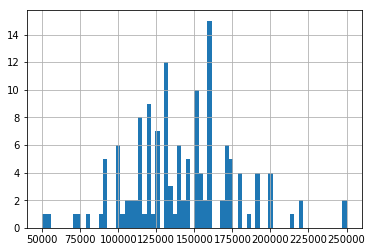

In [904]:
# Salary of different jobs
salaries['salary'].hist(bins = 70)

In [905]:
salaries.title = pd.Categorical(salaries.title)
salaries['title_code'] = salaries.title.cat.codes
salaries= salaries[['location','title','company','summary','title_code','salary','loc_code','comp_code','high_salary']]
salaries.head()


,location,title,company,summary,title_code,salary,loc_code,comp_code,high_salary
0,CA,jr data scientist,Harnham,associate data scientist exciting opportunity ...,2,130000.0,1,22,0
1,MN,sr data scientist,RED SKY Consulting,data architect bi architect data scientist dat...,4,120000.0,9,39,0
2,NY,jr data scientist,DEPARTMENT OF TRANSPORTATION,establish monitor best practice policy procedu...,2,71814.5,12,12,0
3,NY,jr data scientist,"Envisagenics, Inc.",looking expert machine learning genomics rnase...,2,87500.0,12,17,0
4,NY,chief data scientist,Harnham,chief data scientist consulting chief data sci...,0,220000.0,12,22,1


In [906]:
columns = ['location', 'title', 'company', 'summary']
salaries.drop(columns, inplace=True, axis=1)


In [907]:
salaries.head()

,title_code,salary,loc_code,comp_code,high_salary
0,2,130000.0,1,22,0
1,4,120000.0,9,39,0
2,2,71814.5,12,12,0
3,2,87500.0,12,17,0
4,0,220000.0,12,22,1


In [908]:


X_Dtrain = salaries
y_Dtrain = salaries['high_salary']


In [909]:
columns = ['high_salary']
X_Dtrain.drop(columns, inplace=True, axis=1)

In [910]:
X_Dtrain.head()

,title_code,salary,loc_code,comp_code
0,2,130000.0,1,22
1,4,120000.0,9,39
2,2,71814.5,12,12
3,2,87500.0,12,17
4,0,220000.0,12,22


## Splitting Data into Train and Test Data

In [911]:
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_Dtrain, y_Dtrain, test_size=0.2, random_state = 0)


In [912]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from IPython.display import Image, display
from subprocess import call
import pydotplus
import collections

## Decision Tree Classifier - Using Gini

* We have used decision tree classifier for classifying our data into above mean and below mean categories.
* Decision Tree classifier splits the data based on the homogeneity
* The criterion 'gini' specifies the quality of split.

In [913]:
columns = ['salary']
X_Dtrain.drop(columns, inplace=True, axis=1)


In [914]:
X_Dtrain.head()

,title_code,loc_code,comp_code
0,2,1,22
1,4,9,39
2,2,12,12
3,2,12,17
4,0,12,22


In [915]:
clf = tree.DecisionTreeClassifier()

In [916]:
clf.fit(X_Dtrain, y_Dtrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [917]:
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=['title_code','loc_code','comp_code' ],class_names=['Above-Mean', 'Below-Mean'],filled=True, rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data)


colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('salary_decisiontree.png')





True

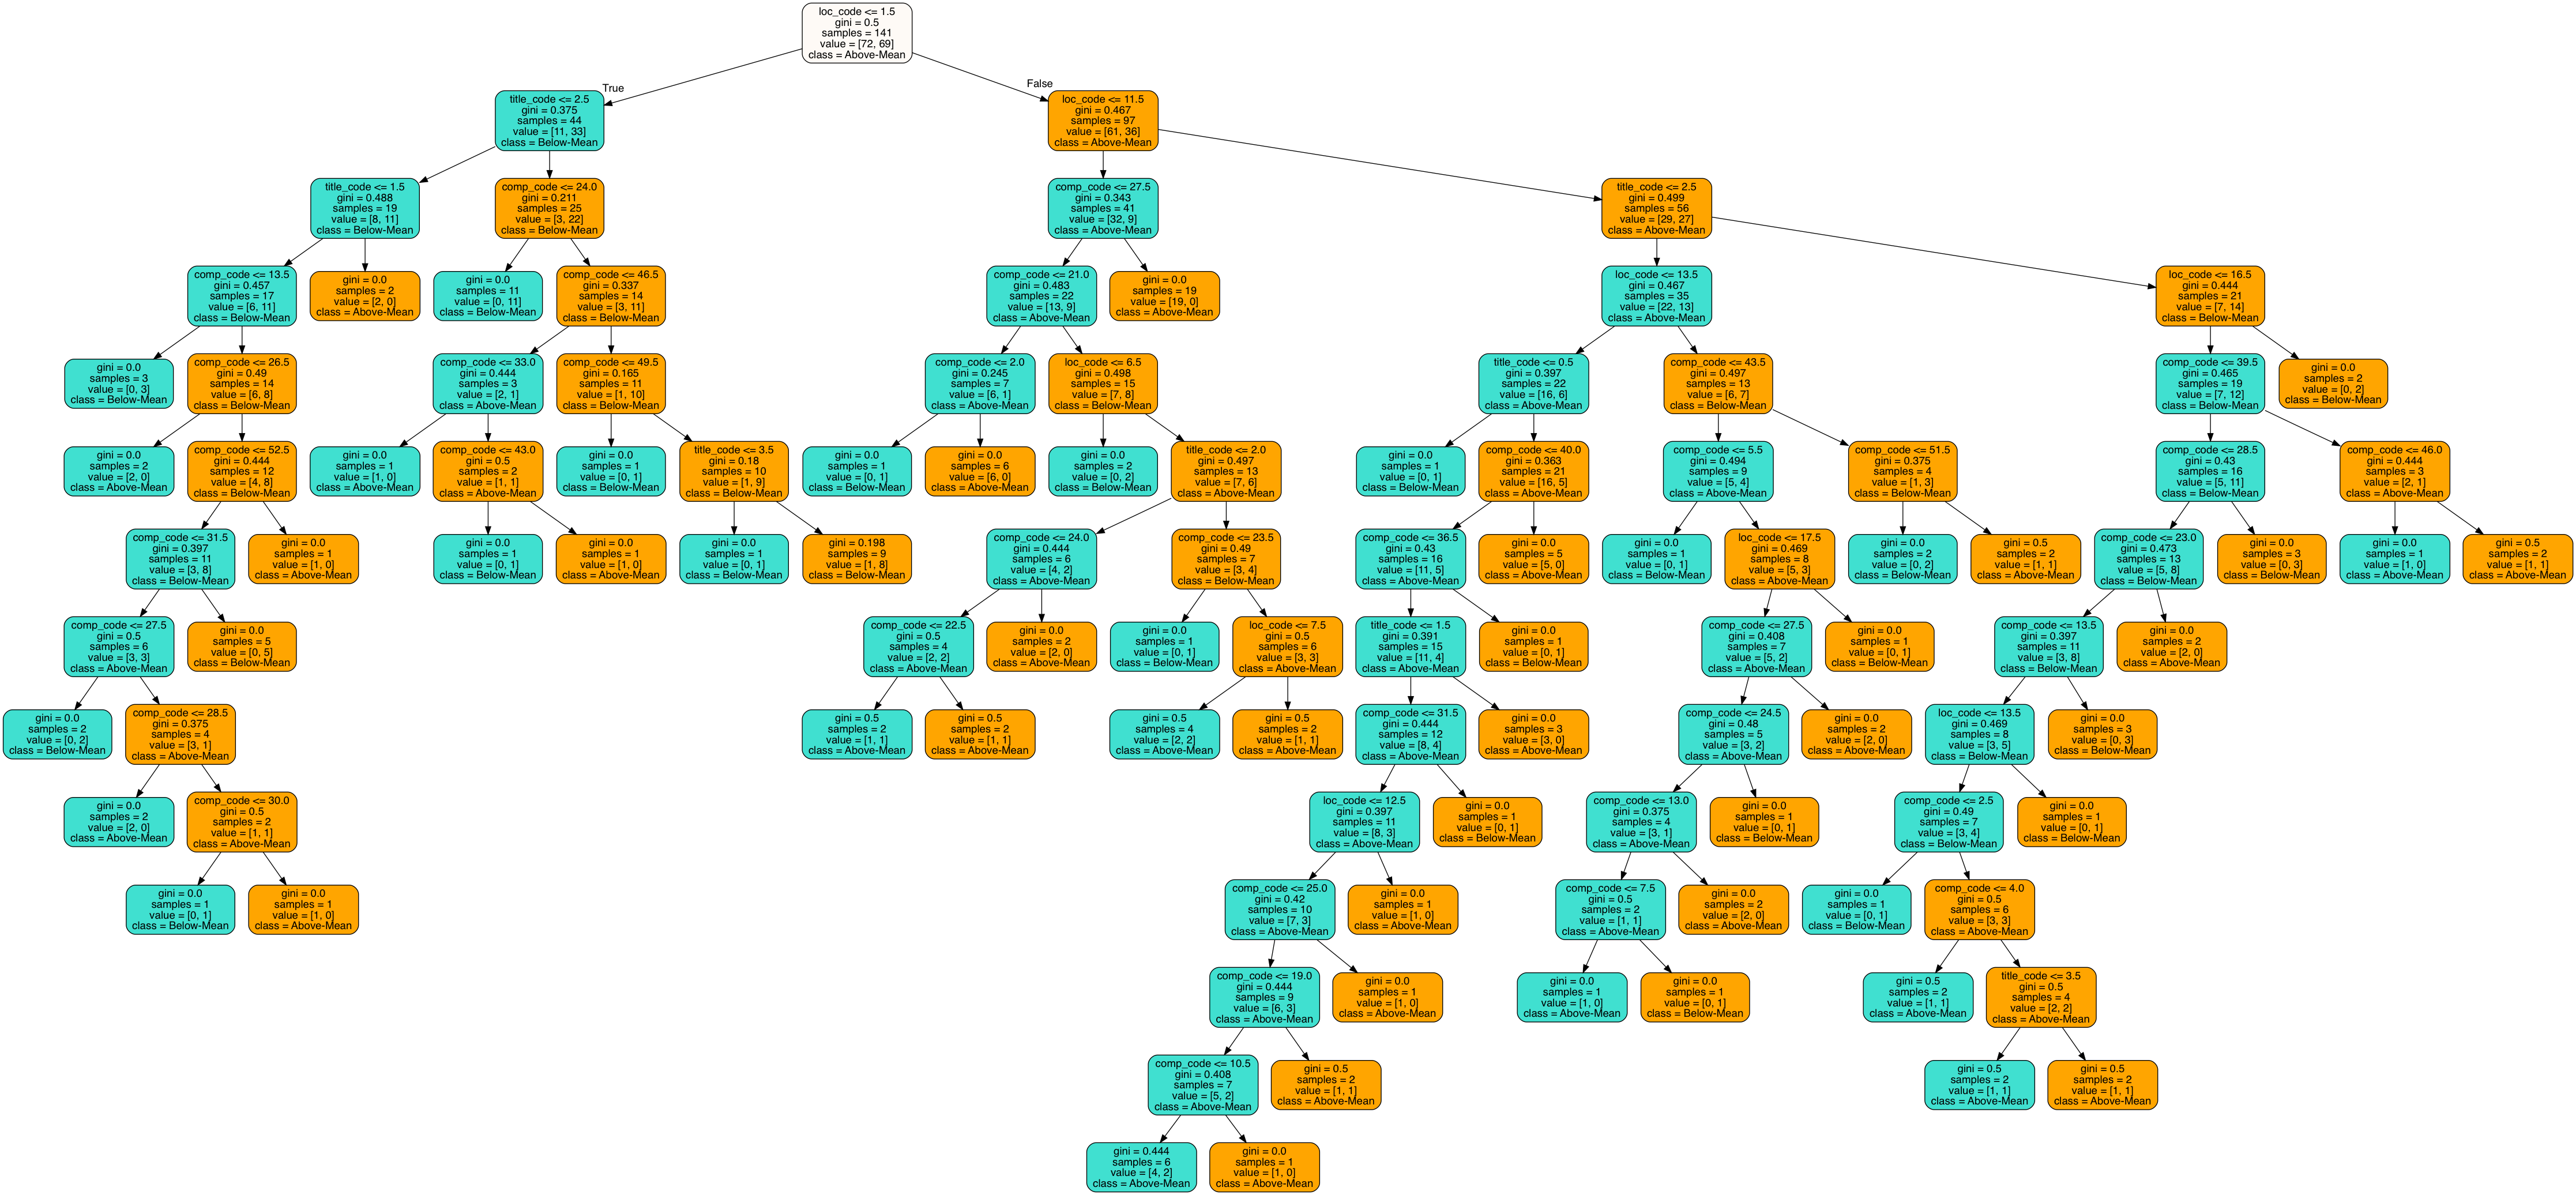

In [951]:
from IPython.display import Image
PATH = !pwd
Image(filename = PATH[0] + "/salary_decisiontree.png")

In [ ]:
img = salary_decisiontree.png.resize((80, 80))

## Heat Map for Visulaization

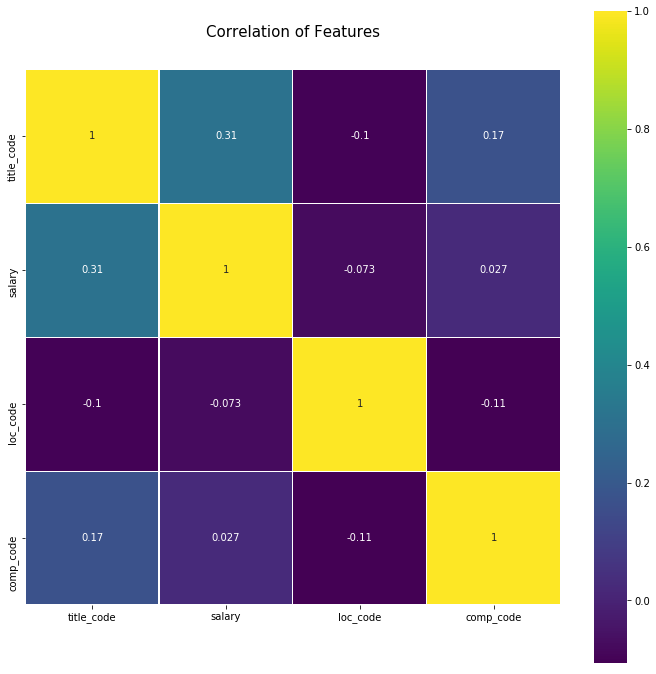

In [919]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train_DT.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)




In [920]:
X_test_DT.head()

,title_code,salary,loc_code,comp_code
45,1,190000.0,1,52
60,1,115000.0,12,43
7,1,130000.0,12,56
51,1,145000.0,1,11
66,1,125000.0,10,41


## Predicting for Test Data

In [921]:
X_test = X_test_DT.drop('salary', axis = 1)
final_test_DT = X_test_DT['salary']
#final_test_DT = X_test_DT
final_test_DT.head()

45    190000.0
60    115000.0
7     130000.0
51    145000.0
66    125000.0
Name: salary, dtype: float64

In [746]:
#columns = ['salary']
#X_test_DT.drop(columns, inplace=True, axis=1)


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [922]:
final_test_DT.head()

45    190000.0
60    115000.0
7     130000.0
51    145000.0
66    125000.0
Name: salary, dtype: float64

In [923]:
prediction = clf.predict(X_test)
print(prediction)


[1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1]


## Accuracy Score

In [925]:
acc_decision_tree = round(clf.score(X_Dtrain, y_Dtrain) * 100, 2)
acc_decision_tree

90.07

In [954]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test_DT,prediction))
print(confusion_matrix(y_test_DT,prediction))

             precision    recall  f1-score   support

          0       0.94      0.94      0.94        17
          1       0.92      0.92      0.92        12

avg / total       0.93      0.93      0.93        29

[[16  1]
 [ 1 11]]
